# Name:
Omri Zafrani 312239932 , Liora Asraf 328931308

# Abstract
For year the supermarket world has been facing difficulties in quantifiying the required merchandise. In this competition, machine learning will be use to predict grocery sales. After a deep exploration of the data, a data engineering was performed. The model was build by using Autoregression Integreted Random Forest, Extreme Gradient Boosting and Linear Regression.After tested all, the Ranodom Forest gave the best fit. The accuracy of the model has been improved by changed the values on the tuning hyperparameters. The precision of the result is calculated by Root Mean Squared Logarithmic Error on the test set and the value is 0.46983.

# Introduction
For year the supermarket world has been facing difficulties in quantifiying the required merchandise. Especially brick-and-mortar grocery stores, which must be very precise with how much inventory to buy. Predict a little over, and grocers are stuck with overstocked, perishable goods. Guess a little under, and popular items quickly sell out, leading to lost revenue and upset customers. More accurate forecasting, thanks to machine learning, could help ensure retailers please customers by having just enough of the right products at the right time. 
In this Kaggle’s competition called ‘Store sales – time series forecasting’, machine learning will be use to predict grocery sales. If successful, more accurate forecasting can decrease food waste related to overstocking and improve customer satisfaction.
The three forecasting methods used in the model are: Random Forest (RF), Linear Regression (LR) and Extreme Gradient Boosting (XGBoost).

Random forests or random decision forests is an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees. For regression tasks, as we have in this competition, the mean or average prediction of the individual trees is returned. The main advantage of RF is that it solves the issue of overfitting in decision trees. In every RF tree, a subset of features is selected randomly at the node’s splitting point. Secondly, RF is more accurate than the decision tree algorithm. The last advantage and probably the most significant reason is that is provides an effective way of handling missing data. [1]

Linear Regression is a class of statistical model for prediction, forecasting, or error reduction. Based on a linear approach for modelling the relationship between the predictors and the target. The main advantage of LR is a very simple algorithm that can be implemented very easily to give satisfactory results. Second, LR fits linearly seperable datasets almost perfectly and is often used to find the nature of the relationship between variables. Third, regularization is a technique that can be easily implemented and is capable of effectively reducing the complexity of a function so as to reduce the risk of overfitting. [2]
Extreme Gradient Boosting (XGBoost) is an open-source library that provides an efficient and effective implementation of the gradient boosting algorithm. Gradient boosting refers to a class of ensemble machine learning algorithms that can be used for classification or regression predictive modeling problems.


# Data Exploration
The first step in solving a riddle is data exploration and analysis, understanding all the data and deriving preliminary conclusions. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. This set contains 6 columns and 3000888 samples. Some additional files include supplementary information that may be useful in building the models. Such as stores, oil, holiday events, sample submissions and transactions. 

# **Imports**

In [1]:
import os
import time
import itertools
import calendar as cal
import numpy as np 
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.signal import periodogram
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.stattools import pacf, acf

DATA_DIR = "/kaggle/input/store-sales-time-series-forecasting"


# plotly settings
plotly_base_params = {
    'template': "plotly_white",
    'title_font': dict(size=29, color='#8a8d93', family="Lato, sans-serif"),
    'font': dict(color='#8a8d93'), 
    'hoverlabel': dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif")
}

In [2]:
def plot_periodogram(ts, detrend='linear', ax=None):
    # fs = (exact value of deprecated '1Y') / '1D'
    fs = pd.Timedelta('365 days 05:49:12') / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts, fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="green")
    ax.set_xscale("log")
    ax.set_xticks([4, 12, 26, 52])
    ax.set_xticklabels([
        "Quarterly (4)",
        "Monthly (12)",
        "Biweekly (26)",
        "Weekly (52)"
        ], rotation=30)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

# **Load Data**

In [3]:
train = pd.read_csv(os.path.join(DATA_DIR, "train.csv"), parse_dates=['date'], infer_datetime_format=True, dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'int32',
    }, usecols=['store_nbr', 'family', 'date', 'sales','onpromotion'])
test = pd.read_csv(os.path.join(DATA_DIR, "test.csv"), parse_dates=['date'], infer_datetime_format=True, dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'int32',
    })
oil = pd.read_csv(os.path.join(DATA_DIR, "oil.csv"), parse_dates=['date'])
holidays_events = pd.read_csv(os.path.join(DATA_DIR, "holidays_events.csv"), parse_dates=['date'], infer_datetime_format=True, dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'str',
        'transferred': 'bool',
    })
transactions = pd.read_csv(os.path.join(DATA_DIR, "transactions.csv"), parse_dates=['date'])
stores = pd.read_csv(os.path.join(DATA_DIR, "stores.csv"))

print(f"Training Data: from {train.date.min()} to {train.date.max()} - {train.date.max() - train.date.min()}")
print(f"Testing Data: from {test.date.min()} to {test.date.max()} - {test.date.max() - test.date.min()}")

Training Data: from 2013-01-01 00:00:00 to 2017-08-15 00:00:00 - 1687 days 00:00:00
Testing Data: from 2017-08-16 00:00:00 to 2017-08-31 00:00:00 - 15 days 00:00:00


In [4]:
train.head()

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


# **Data Analysis**

We will use the 'calendar_df' dataframe as a table with all the additional information we can extract from the oil, holidays, stores and transcations tables. 

The calendar holds the information since 1/1/2013 (start of train set) until 31/8/2017 (end of test set).

In [5]:
# calendar dataset covering train + test dates
calendar_df = pd.DataFrame(pd.date_range(train.date.min(), test.date.max()), columns=['date'])

In [6]:
# compute 7-days moving average and 14-days MA
oil['ma_oil7'] = oil['dcoilwtico'].rolling(7).mean()#weekly MA
oil['ma_oil14'] = oil['dcoilwtico'].rolling(14).mean()#BiWeekly MA
oil = oil.set_index('date')


In [7]:
# Plot oil price Vs Weekly/BiWeekly MA
fig = go.Figure()
fig.add_scatter(x=oil.index, y=oil.dcoilwtico,
                mode='lines', name='Oil Price',
                line=dict(color='#428bca', width=2))
fig.add_scatter(x=oil.index, y=oil.ma_oil7.fillna(method='ffill'),
                mode='lines', name='Weekly MA',
                line=dict(color='purple', width=1))
fig.add_scatter(x=oil.index, y=oil.ma_oil14.fillna(method='ffill'),
                mode='lines', name='BiWeekly MA',
                line=dict(color='green', width=1))
fig.update_layout(title='Oil price Vs Weekly/BiWeekly MA', **plotly_base_params)
fig.show()

BiWeekly moving average does not seems to be a good fit, hence, we will extend training set with oil price based on its Weekly MA.

Add MA Oil price feature to the extended calendar dataframe.

In [8]:
# adding oil price to calendar
calendar_df = calendar_df.merge(oil, on="date", how="left")
calendar_df['ma_oil7'].fillna(method='ffill', inplace=True)
oil.drop(['dcoilwtico','ma_oil14'], axis=1, inplace=True)
calendar_df.drop(['dcoilwtico','ma_oil14'], axis=1, inplace=True)

# **Periodic Analysis**

**Parsing dates**

In [9]:
calendar_df['date'] = calendar_df['date'].astype('datetime64[ns]')
calendar_df['year'] = calendar_df['date'].dt.year
calendar_df['month'] = calendar_df['date'].dt.month
calendar_df['monthday'] = calendar_df['date'].dt.day
calendar_df['week'] = calendar_df['date'].dt.isocalendar().week
calendar_df['quarter'] = calendar_df['date'].dt.quarter
calendar_df['weekday'] = calendar_df['date'].dt.dayofweek

**Sales periodic analysis**

In [10]:
df_sales = train.groupby('date').agg({"sales" : "sum"}).reset_index()
df_sales['sales_ma'] = df_sales['sales'].rolling(7).mean()


In [11]:
fig = go.Figure()
fig.add_scatter(x=df_sales['date'], y=df_sales['sales'],
                mode='lines', name='Sales',
                line=dict(color='#428bca', width=2))

fig.update_layout(title='Sales Trend', **plotly_base_params)
fig.show()

trend up in sales over time.

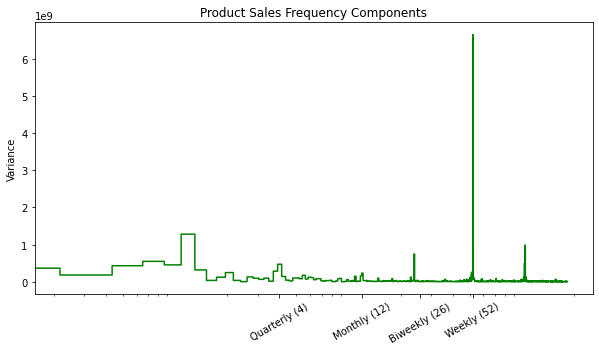

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = plot_periodogram(df_sales["sales"], ax=ax)
ax.set_title("Product Sales Frequency Components")
plt.show()

Looking at the periodogram will reveal that the best way for analysis is in predictions in weekly averages. 

In [13]:
#sales transactions correlation

df_trans = transactions.groupby('date').agg({"transactions" : "sum"}).reset_index()
fig = go.Figure()
fig.add_scatter(x=df_sales['sales'], y=df_trans['transactions'],
                mode='markers', marker=dict(color='black', size=2),
                name='Sales/Transactions')

fig.update_layout(title='Sales Transaction Correlation', **plotly_base_params)
fig.show()

Noticing correlation between sales and transactions.

#  Sales with Holidays data

From a review in other notebooks we found that there is actually an error in the holidays dataset.

Viernes Santo is the 'Good Friday', according to the dataset, the 'Good Friday' was on 2013 April 29th:

In [14]:
holidays_events[holidays_events.description=='Viernes Santo']

,date,type,locale,locale_name,description,transferred
51,2013-04-29,Holiday,National,Ecuador,Viernes Santo,False
99,2014-04-18,Holiday,National,Ecuador,Viernes Santo,False
166,2015-04-03,Holiday,National,Ecuador,Viernes Santo,False
215,2016-03-25,Holiday,National,Ecuador,Viernes Santo,False
306,2017-04-14,Holiday,National,Ecuador,Viernes Santo,False


While according to Google, it was actually on March 29th:
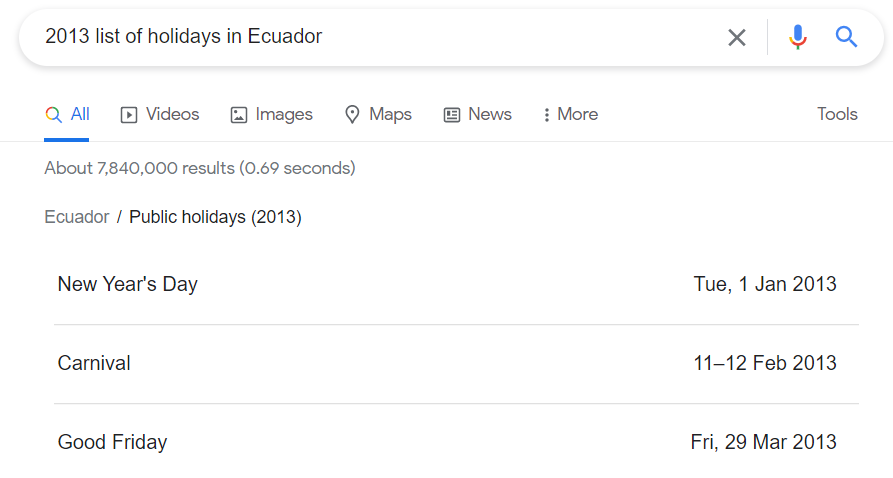

So we will correct this mistake.

In [15]:
# 'Good Friday' mistake correction
holidays_events['date'][holidays_events.description=='Viernes Santo'].replace({'2013-04-29': pd.to_datetime('2013-03-29')}, inplace=True)
holidays_events = holidays_events.set_index('date').sort_index()
# keep National level only for simplicity
holidays_events = holidays_events[holidays_events.locale=='National']
# keep only one event per day
holidays_events = holidays_events.groupby(holidays_events.index).first()

In [16]:
holidays_events.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False


In [17]:
# data
avg_sales = train.groupby('date').agg({"sales" : "mean"}).reset_index()
avg_sales_holidays = avg_sales.merge(holidays_events, on='date', how='left')
avg_sales_holidays = avg_sales_holidays.rename(columns={"type": "event_type"})

fig = go.Figure()
fig.add_scatter(x=avg_sales_holidays.date, y=avg_sales_holidays.sales,
                mode='lines', name='Avg Sales', line=dict(width=.5,color='black'))
fig.add_scatter(x=avg_sales_holidays['date'][avg_sales_holidays.event_type=='Holiday'],
                y=avg_sales_holidays['sales'][avg_sales_holidays.event_type=='Holiday'],
                mode='markers', name='Holidays',
                marker=dict(color='red', size=4))
fig.add_scatter(x=avg_sales_holidays['date'][avg_sales_holidays.event_type=='Event'],
                y=avg_sales_holidays['sales'][avg_sales_holidays.event_type=='Event'],
                mode='markers', name='Events',
                marker=dict(color='blue', size=5))
fig.update_layout(title='Avg Sales with Holydays and Events',
                  height=500, width=1000, **plotly_base_params)
fig.show()

 all stores are closed on New Year's Day, so sales are 0 at these days.

**Sales Holidays Histogram**

In [18]:
avg_sales_holidays.head()

,date,sales,event_type,locale,locale_name,description,transferred
0,2013-01-01,1.409438,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-02,278.390808,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,202.840195,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,198.911148,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,267.873230,Work Day,National,Ecuador,Recupero puente Navidad,False


In [19]:
avg_sales_holidays['description'] = avg_sales_holidays['description'].fillna('Usual Day')
hist_df = avg_sales_holidays.groupby('description')['sales'].mean()

hist_df.head()
px.bar(data_frame=hist_df,title='AVG Sales at Holiday,Events and Usual days',y='sales')

* Highest average sales at Cyber Monday and Traslado primer grito de independence holidays.
* No sales at the 01.01 at each year(primer dia del ano holiday).


**Pay days**

In [20]:
import calendar
calendar_df['LastDayOfMonth'] = calendar_df.set_index('date').index.map(lambda x: calendar.monthrange(x.year, x.month)[1])
calendar_df['Payday'] = ((calendar_df['monthday'] == calendar_df['LastDayOfMonth']) | (calendar_df['monthday'] == 15)).astype(int)
calendar_df.drop('LastDayOfMonth', axis=1, inplace=True)

In [21]:
avg_sales = avg_sales.merge(calendar_df, on="date")
fig = go.Figure()
fig.add_scatter(x=avg_sales.date, y=avg_sales.sales,
                mode='lines', name='Avg Sales', line=dict(width=.5,color='black'))
fig.add_scatter(x=avg_sales['date'][avg_sales.Payday==1],
                y=avg_sales['sales'][avg_sales.Payday==1],
                mode='markers', name='Paydays',
                marker=dict(color='red', size=4))
fig.update_layout(title='Avg Sales with Paydays',
                  height=500, width=1000, **plotly_base_params)
fig.show()

**Work Days and Holidays**

Add feature 'Work day' (WD), which is 0 for Saturdays and Sundays and 1 for every other day which is not a holiday.

pandas' dt.dayofweek is the day of the week with Monday=0, Sunday=6. Hence, we are interested in dayofweek > 4.

NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).


In [22]:
calendar_df = calendar_df.merge(holidays_events, on='date', how='left')
calendar_df['WD'] = 1
calendar_df.loc[calendar_df.weekday > 4, 'WD'] = 0
calendar_df.loc[(calendar_df.type == 'Holiday') & (calendar_df.transferred == True), 'WD'] = 1
calendar_df.loc[(calendar_df.type == 'Holiday') & (calendar_df.transferred == False), 'WD'] = 0
calendar_df.loc[(calendar_df.type == 'Work Day'), 'WD'] = 1
calendar_df.loc[(calendar_df.type == 'Bridge'), 'WD'] = 0
calendar_df.loc[(calendar_df.type == 'Transfer'), 'WD'] = 0

calendar_df.drop(holidays_events.columns, axis=1, inplace=True)

In [23]:
avg_sales = avg_sales.merge(calendar_df, on="date", how="left")

In [24]:
# Plot sales on work days \ off days
fig = go.Figure()
fig.add_scatter(x=avg_sales.date, y=avg_sales.sales,
                mode='lines', name='Avg Sales', line=dict(width=.5,color='black'))
fig.add_scatter(x=avg_sales['date'][avg_sales.WD==1],
                y=avg_sales['sales'][avg_sales.WD==1],
                mode='markers', name='Work Days',
                marker=dict(color='red', size=4))
fig.add_scatter(x=avg_sales['date'][avg_sales.WD==0],
                y=avg_sales['sales'][avg_sales.WD==0],
                mode='markers', name='Not Work Days',
                marker=dict(color='cyan', size=4))
fig.update_layout(title='Avg Sales with Work \ Not Work Days',
                  height=500, width=1000, **plotly_base_params)
fig.show()

Sales peeks are usually on Day offs. This might be an interesting feature.

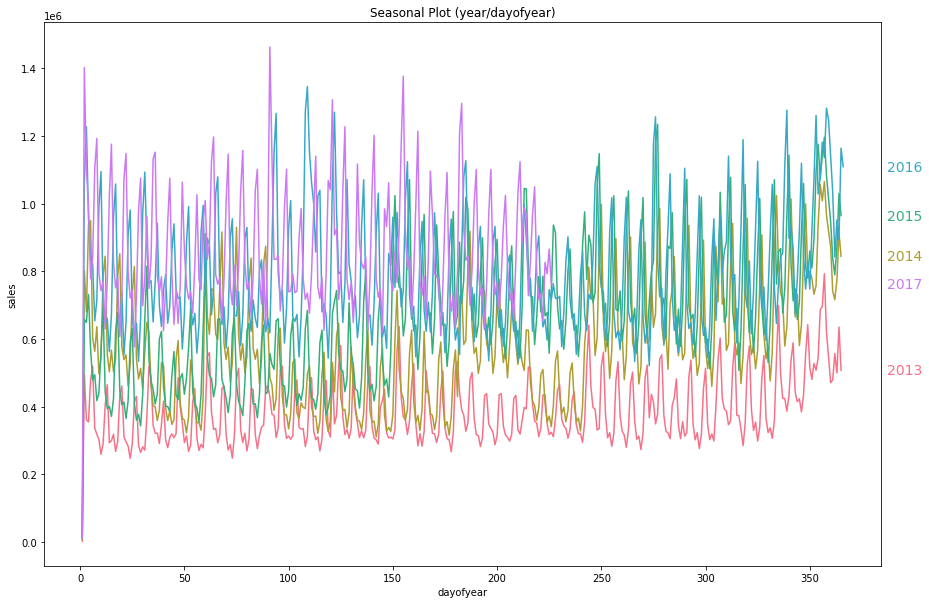

In [25]:
df_sales = df_sales.set_index('date').to_period("D")
df_sales['year'] = df_sales.index.year
df_sales['dayofyear'] = df_sales.index.dayofyear

#seasonal plots
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq, y=y, data=X, hue=period, ci=False,
        ax=ax, palette=palette, legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name, xy=(1, y_), xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points", size=14, va="center",
        )
    return ax
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 10))
seasonal_plot(df_sales, y="sales", period="year", freq="dayofyear", ax=ax1)
plt.show()

A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. 

Let's view 2016 year sales plot.

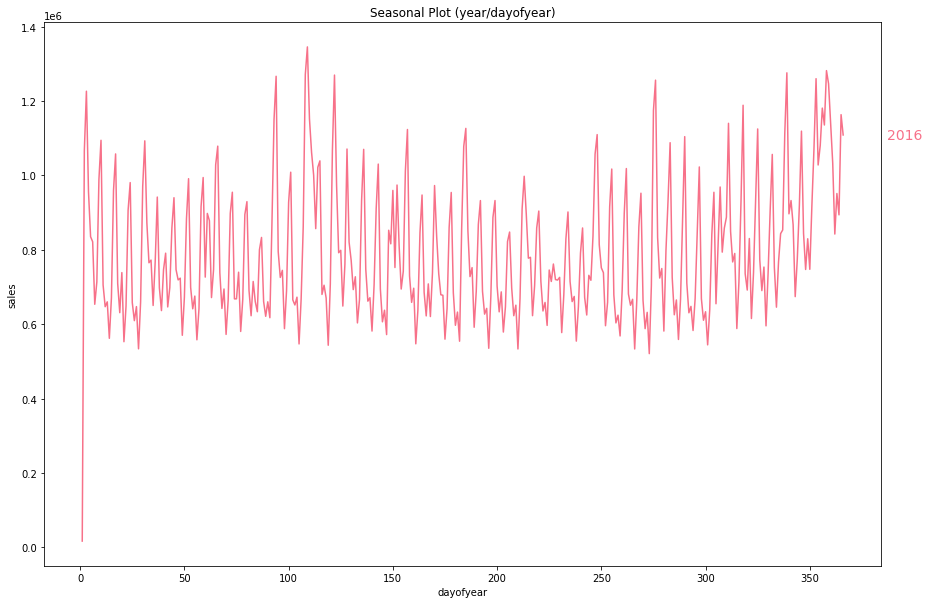

In [26]:
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 10))
seasonal_plot(df_sales.loc['2016'], y="sales", period="year", freq="dayofyear", ax=ax1)
plt.show()

People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

# Features and Models

In [27]:
train = train.set_index(['store_nbr', 'family', 'date']).sort_index()
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [28]:
promotions = train.drop('sales', axis=1)
promotions = promotions.append(test.drop('id', axis=1))
promotions = promotions.reset_index(['store_nbr','family'])
promotions['store_nbr'] = promotions['store_nbr'].astype('int32')
promotions = promotions.reset_index()
promotions = pd.DataFrame(promotions.groupby(['date','store_nbr'])['onpromotion'].mean())
promotions = promotions.reset_index().set_index(['date', 'store_nbr'])
promotions

onpromotion
date       store_nbr             
2013-01-01 1             0.000000
           2             0.000000
           3             0.000000
           4             0.000000
           5             0.000000
...                           ...
2017-08-31 50            6.030303
           51            5.333333
           52            6.090909
           53            4.636364
           54            4.363636

[91800 rows x 1 columns]

In [29]:
stores_by_date = promotions.reset_index().merge(stores, how="left").set_index('date').drop('state', axis=1)
# Encode categorial features
stores_by_date = pd.get_dummies(stores_by_date, columns=['city', 'type'], drop_first=True)

In [30]:
stores_by_date

,store_nbr,onpromotion,cluster,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,...,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,type_B,type_C,type_D,type_E
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,0.000000,13,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2013-01-01,2,0.000000,13,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2013-01-01,3,0.000000,8,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2013-01-01,4,0.000000,9,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2013-01-01,5,0.000000,4,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,50,6.030303,14,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-08-31,51,5.333333,17,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-08-31,52,6.090909,11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
stores_by_date.reset_index().set_index(['date'])

,store_nbr,onpromotion,cluster,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,...,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,type_B,type_C,type_D,type_E
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,0.000000,13,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2013-01-01,2,0.000000,13,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2013-01-01,3,0.000000,8,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2013-01-01,4,0.000000,9,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2013-01-01,5,0.000000,4,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,50,6.030303,14,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-08-31,51,5.333333,17,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-08-31,52,6.090909,11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
calendar_df = calendar_df.fillna(method='bfill')
# Encode categorial features
calendar_df = pd.get_dummies(calendar_df.drop('year', axis=1), columns=['weekday'], drop_first=False)

In [33]:
calendar_df

,date,ma_oil7,month,monthday,week,quarter,Payday,WD,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2013-01-01,93.218571,1,1,1,1,0,0,0,1,0,0,0,0,0
1,2013-01-02,93.218571,1,2,1,1,0,1,0,0,1,0,0,0,0
2,2013-01-03,93.218571,1,3,1,1,0,1,0,0,0,1,0,0,0
3,2013-01-04,93.218571,1,4,1,1,0,1,0,0,0,0,1,0,0
4,2013-01-05,93.218571,1,5,1,1,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699,2017-08-27,47.720000,8,27,34,3,0,0,0,0,0,0,0,0,1
1700,2017-08-28,47.624286,8,28,35,3,0,1,1,0,0,0,0,0,0
1701,2017-08-29,47.320000,8,29,35,3,0,1,0,1,0,0,0,0,0
1702,2017-08-30,47.115714,8,30,35,3,0,1,0,0,1,0,0,0,0


dates_info is a DataFrame contains the information regarding the stores (such as the city) combined with the information regarding the date (such as oil price MA). 

In [34]:
dates_info = stores_by_date.reset_index().merge(calendar_df, how='inner', on='date').set_index('date')
dates_info

,store_nbr,onpromotion,cluster,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,...,quarter,Payday,WD,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,0.000000,13,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2013-01-01,2,0.000000,13,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2013-01-01,3,0.000000,8,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2013-01-01,4,0.000000,9,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2013-01-01,5,0.000000,4,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,50,6.030303,14,0,0,0,0,0,0,0,...,3,1,1,0,0,0,1,0,0,0
2017-08-31,51,5.333333,17,0,0,0,0,0,0,0,...,3,1,1,0,0,0,1,0,0,0
2017-08-31,52,6.090909,11,0,0,0,0,0,0,0,...,3,1,1,0,0,0,1,0,0,0


# Train, Validation and Test periods

### Train period

First, we need to decide on 'train' and 'test' periods.

A reasonable choice for beginning of training is when all stores are already exist and selling.

Let's check when was the latest opening of a store:

In [35]:
a = train.groupby(["date","store_nbr"]).sum().reset_index()
a = a[a["sales"] > 0].groupby("store_nbr")[["date"]].min().sort_values(by="date",ascending = False).head(5)
a

,date
store_nbr,
52,2017-04-20
22,2015-10-09
42,2015-08-21
21,2015-07-24
29,2015-03-20


Latest store (52) started selling at 2017-04-20, so we will start learning from day after.

We split our train set into train and validation set.
The validation set lasts 15 days.

In [36]:
from datetime import timedelta

test_start_date = test.index.get_level_values('date').min()
test_end_date = test.index.get_level_values('date').max()

train_start_date = "2017-04-20"
train_end_date = train.index.get_level_values('date').max() - timedelta(days=16)

evaluation_start_date = train.index.get_level_values('date').max() - timedelta(days=15)
evaluation_end_date = train.index.get_level_values('date').max()

print(f"Train dates: {train_start_date} - {train_end_date} \n Evaluation dates: {evaluation_start_date} - {evaluation_end_date} \n Test dates: {test_start_date} - {test_end_date}")

Train dates: 2017-04-20 - 2017-07-30 00:00:00 
 Evaluation dates: 2017-07-31 00:00:00 - 2017-08-15 00:00:00 
 Test dates: 2017-08-16 00:00:00 - 2017-08-31 00:00:00


A function to extract the samples and labels for the model to learn.

X is a sample of date and a store number, appended with extra information, such as, work day\not, oil price and mean onpromotion on that day.

Y is a vector containing the sales for each category (AUTOMOTIVE, BEAUTY, ...) for each date and store.


In [37]:

def get_X_Y(start, end):
    y = train.drop('onpromotion', axis=1).reset_index().copy().append(test.reset_index().drop(['id', 'onpromotion'], axis=1))
    y = y.loc[(y['date'] >= start) & (y['date'] <= end)]
    y['store_nbr'] = y['store_nbr'].astype(int)
    y = y.set_index(['date', 'store_nbr','family']).sort_index().unstack('family')
    # compute seasonnal features
    fourier = CalendarFourier(freq='W', order=4)
    dp = DeterministicProcess(index=y.unstack('store_nbr').index,
                              constant=False,
                              order=1,
                              seasonal=False,
                              additional_terms=[fourier],
                              drop=True)
    X = dp.in_sample()
    # add date features
    X = X.merge(dates_info, how='left', left_index=True, right_index=True).reset_index().set_index(['date','store_nbr'])
    return X, dp, y

In [38]:
# get X,y for train period
X, dp,y  = get_X_Y(train_start_date, train_end_date)

In [39]:
X

trend  sin(1,freq=W-SUN)  cos(1,freq=W-SUN)  \
date       store_nbr                                                
2017-04-20 1            1.0           0.433884          -0.900969   
           2            1.0           0.433884          -0.900969   
           3            1.0           0.433884          -0.900969   
           4            1.0           0.433884          -0.900969   
           5            1.0           0.433884          -0.900969   
...                     ...                ...                ...   
2017-07-30 50         102.0          -0.781831           0.623490   
           51         102.0          -0.781831           0.623490   
           52         102.0          -0.781831           0.623490   
           53         102.0          -0.781831           0.623490   
           54         102.0          -0.781831           0.623490   

                      sin(2,freq=W-SUN)  cos(2,freq=W-SUN)  sin(3,freq=W-SUN)  \
date       store_nbr                                                            
2017-04-20 1                  -0.781831           0.623490           0.974928   
           2                  -0.781831           0.623490           0.974928   
           3                  -0.781831           0.623490           0.974928   
           4                  -0.781831           0.623490           0.974928   
           5                  -0.781831           0.623490           0.974928   
...                                 ...                ...                ...   
2017-07-30 50                 -0.974928          -0.222521          -0.433884   
           51                 -0.974928          -0.222521          -0.433884   
           52                 -0.974928          -0.222521          -0.433884   
           53                 -0.974928          -0.222521          -0.433884   
           54                 -0.974928          -0.222521          -0.433884   

                      cos(3,freq=W-SUN)  onpromotion  cluster  city_Babahoyo  \
date       store_nbr                                                           
2017-04-20 1                  -0.222521     5.181818       13              0   
           2                  -0.222521     5.757576       13              0   
           3                  -0.222521     7.484848        8              0   
           4                  -0.222521     5.515152        9              0   
           5                  -0.222521     5.424242        4              0   
...                                 ...          ...      ...            ...   
2017-07-30 50                 -0.900969     5.515152       14              0   
           51                 -0.900969     5.151515       17              0   
           52                 -0.900969     5.575758       11              0   
           53                 -0.900969     4.575758       13              0   
           54                 -0.900969     5.666667        3              0   

                      ...  quarter  Payday  WD  weekday_0  weekday_1  \
date       store_nbr  ...                                              
2017-04-20 1          ...        2       0   1          0          0   
           2          ...        2       0   1          0          0   
           3          ...        2       0   1          0          0   
           4          ...        2       0   1          0          0   
           5          ...        2       0   1          0          0   
...                   ...      ...     ...  ..        ...        ...   
2017-07-30 50         ...        3       0   0          0          0   
           51         ...        3       0   0          0          0   
           52         ...        3       0   0          0          0   
           53         ...        3       0   0          0          0   
           54         ...        3       0   0          0          0   

                      weekday_2  weekday_3  weekday_4  weekday_5  weekday_6  
date       sto

In [40]:
y

sales                                                \
family               AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date       store_nbr                                                            
2017-04-20 1                2.0       0.0    2.0    1948.0   0.0   420.877014   
           2               10.0       0.0    4.0    2347.0   0.0   565.531006   
           3               11.0       1.0    5.0    6414.0   0.0  1052.605957   
           4                3.0       0.0    3.0    1874.0   0.0   297.260010   
           5                4.0       0.0    2.0    1458.0   0.0   210.942993   
...                         ...       ...    ...       ...   ...          ...   
2017-07-30 50               9.0       0.0   11.0    7726.0   0.0   703.286011   
           51               8.0       0.0   15.0    7150.0   0.0  1288.968994   
           52              14.0       0.0    8.0    5867.0   0.0  1063.463013   
           53              11.0       0.0    4.0    3605.0   0.0   715.195984   
           54              12.0       0.0    7.0    4394.0   0.0   426.000000   

                                                               ...            \
family               CELEBRATION CLEANING   DAIRY        DELI  ... MAGAZINES   
date       store_nbr                                           ...             
2017-04-20 1                20.0    696.0   666.0   93.429001  ...       6.0   
           2                11.0    829.0   729.0  211.662994  ...      10.0   
           3                39.0   1885.0  1944.0  317.946991  ...      28.0   
           4                12.0    786.0   645.0  194.755005  ...      11.0   
           5                12.0    602.0   434.0  185.695007  ...      11.0   
...                          ...      ...     ...         ...  ...       ...   
2017-07-30 50               36.0   2771.0  1381.0  717.322021  ...       8.0   
           51                8.0   1993.0  2159.0  354.876007  ...      15.0   
           52               16.0   2047.0  1319.0  456.858002  ...      13.0   
           53               12.0   1653.0   803.0  324.863007  ...       3.0   
           54                8.0   2831.0   444.0  351.000000  ...       3.0   

                                                             \
family                     MEATS PERSONAL CARE PET SUPPLIES   
date       store_nbr                                          
2017-04-20 1          335.494995         131.0          3.0   
           2          375.869995         229.0         12.0   
           3          656.476990         421.0         13.0   
           4          235.147003         157.0          7.0   
           5          226.556000         190.0          7.0   
...                          ...           ...          ...   
2017-07-30 50         538.137024         761.0         10.0   
           51         720.874023         525.0         30.0   
           52         538.450012         513.0         17.0   
           53         329.597992         393.0         13.0   
           54          76.667000         380.0          0.0   

                                                                         \
family               PLAYERS AND ELECTRONICS     POULTRY PREPARED FOODS   
date       store_nbr                                                      
2017-04-20 1                             7.0  264.397003      83.920998   
           2                             4.0  381.740997      75.897003   
           3                            33.0  945.737000     304.641998   
           4                             7.0  289.342010      28.966000   
           5                             7.0  174.535004      47.561001   
...                                      ...         ...            ...   
2017-07-30 50                           33.0  513.773987      72.621002   
           51                           20.0  918.620972     168.102997   
           52                           27.0  544.042969     1

# Models Training

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

Linear Model Training

In [42]:
linear_model = LinearRegression().fit(X, y)
y_fit_linear = pd.DataFrame(linear_model.predict(X).clip(0.0), index=X.index, columns=y.columns)
y_fit_linear.head()

sales                                             \
family               AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS   
date       store_nbr                                                         
2017-04-20 1           5.371414  0.136080  3.864875  2781.228197  0.195742   
           2           5.434153  0.141746  3.904053  2841.287345  0.195029   
           3           6.773746  0.212389  5.450680  4073.115022  0.221709   
           4           6.328837  0.182275  5.030832  3657.319470  0.218386   
           5           6.574257  0.198260  2.771601  1818.387181  0.175047   

                                                                         \
family               BREAD/BAKERY CELEBRATION     CLEANING        DAIRY   
date       store_nbr                                                      
2017-04-20 1           454.762455   17.419247   731.519439   866.896555   
           2           464.921312   17.819004   749.523790   882.228310   
           3           642.667746   23.580629  1066.639885  1194.843131   
           4           578.459787   21.300568   952.425445  1089.068478   
           5           316.501137   18.246117   956.034490   585.899177   

                                  ...                                       \
family                      DELI  ...  MAGAZINES       MEATS PERSONAL CARE   
date       store_nbr              ...                                        
2017-04-20 1          204.340233  ...   9.043797  438.662115    227.267456   
           2          208.581783  ...   9.158944  451.931151    231.165213   
           3          281.708218  ...  12.931998  549.745243    289.954922   
           4          255.117296  ...  11.852551  492.749777    267.201202   
           5           92.534824  ...   9.000029  242.692886    173.590237   

                                                                       \
family               PET SUPPLIES PLAYERS AND ELECTRONICS     POULTRY   
date       store_nbr                                                    
2017-04-20 1             8.693655                9.718565  444.177489   
           2             8.734796                9.800864  456.601420   
           3            12.558029               13.925441  568.398294   
           4            11.677323               12.868354  510.990356   
           5             6.175243                6.633422  219.896010   

                                                                             \
family               PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date       store_nbr                                                          
2017-04-20 1              84.734160  2266.818560                  13.709593   
           2              86.256585  2354.822297                  13.672777   
           3             129.088950  3652.065956                  13.838450   
           4             116.227637  3144.354051                  13.909174   
           5              92.419119  1818.384032                  20.228672   

                                 
family                  SEAFOOD  
date       store_nbr             
2017-04-20 1          28.183286  
           2          28.849622  
           3          40.450100  
           4          36.250234  
           5          13.296885  

[5 rows x 33 columns]

RF Model Training

In [43]:
RF_model = RandomForestRegressor(random_state=13, n_jobs=-1).fit(X,y)
y_fit_rf = pd.DataFrame(RF_model.predict(X).clip(0.0), index=X.index, columns=y.columns)
y_fit_rf.head()

sales                                                \
family               AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date       store_nbr                                                            
2017-04-20 1               2.76      0.00   2.59   2009.89  0.07   414.996169   
           2               8.28      0.02   4.16   2346.15  0.00   530.146373   
           3              10.55      0.84   5.76   6034.93  0.07  1002.384299   
           4               3.27      0.00   2.68   1961.26  0.27   306.420656   
           5               4.86      0.05   3.13   1556.88  0.00   236.400296   

                                                                ...            \
family               CELEBRATION CLEANING    DAIRY        DELI  ... MAGAZINES   
date       store_nbr                                            ...             
2017-04-20 1               16.89   694.19   670.21  118.204440  ...      6.28   
           2               11.98   819.85   739.12  199.242386  ...      9.24   
           3               36.09  1714.26  1799.24  295.380514  ...     26.27   
           4               10.35   777.35   656.92  180.776754  ...      9.05   
           5               16.26   666.16   458.87  178.463365  ...      9.96   

                                                             \
family                     MEATS PERSONAL CARE PET SUPPLIES   
date       store_nbr                                          
2017-04-20 1          327.281027        144.26         4.60   
           2          364.407207        214.56        10.60   
           3          589.891825        383.16        13.04   
           4          253.498760        160.05         6.94   
           5          210.650980        190.63         5.15   

                                                                         \
family               PLAYERS AND ELECTRONICS     POULTRY PREPARED FOODS   
date       store_nbr                                                      
2017-04-20 1                            7.63  280.126521      77.124148   
           2                            6.13  372.651007      77.911712   
           3                           27.90  849.381978     265.317619   
           4                            7.16  298.885297      34.525920   
           5                            6.61  171.959782      45.338140   

                                                                         
family                    PRODUCE SCHOOL AND OFFICE SUPPLIES    SEAFOOD  
date       store_nbr                                                     
2017-04-20 1          2120.727059                       0.08  24.692100  
           2          2139.532089                       0.69  20.350920  
           3          5576.950925                       0.37  64.295932  
           4          1704.524504                       0.08  16.836530  
           5          1095.891344                       1.85  12.669920  

[5 rows x 33 columns]

XGBoost Model Training

In [44]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
estimators_nbr=100
rate_learning=0.1
maximun_depth=2
alfa=10
X_train=X.copy()
X_train['week']=X_train['week'].astype(int)
xg_reg = xgb.XGBRegressor(colsample_bytree=0.3, learning_rate = rate_learning,
                max_depth = maximun_depth, alpha = alfa, n_estimators = estimators_nbr)
model_xgboost=xg_reg.fit(X_train,y)
y_fit_xgboost = pd.DataFrame(model_xgboost.predict(X_train).clip(0.0), index=X.index, columns=y.columns)
y_fit_xgboost.head()



sales                                             \
family               AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS   
date       store_nbr                                                         
2017-04-20 1           5.000073  0.031607  4.235252  2589.677002  0.270370   
           2           5.140976  0.031607  4.529081  2817.870605  0.270370   
           3           6.493235  0.527039  6.607804  4965.305176  0.271707   
           4           4.435731  0.053016  3.390270  2835.821533  0.271707   
           5           4.973872  0.148317  3.090824  1623.003784  0.150366   

                                                                         \
family               BREAD/BAKERY CELEBRATION     CLEANING        DAIRY   
date       store_nbr                                                      
2017-04-20 1           496.365173   17.765879   928.438049   875.668762   
           2           534.015503   18.805330  1008.012817   932.130615   
           3           739.140015   28.666964  1241.531006  1437.688599   
           4           507.710907   20.419798   976.930603   969.187988   
           5           303.286041   14.636646   768.199951   572.250671   

                                  ...                                       \
family                      DELI  ...  MAGAZINES       MEATS PERSONAL CARE   
date       store_nbr              ...                                        
2017-04-20 1          168.844574  ...   8.224318  416.135132    205.025864   
           2          185.723053  ...   8.984961  416.135132    223.170151   
           3          252.190964  ...  16.759111  528.115051    295.973450   
           4          155.400879  ...   9.469630  424.154968    214.427551   
           5          107.789040  ...   8.359045  209.803589    176.189636   

                                                                       \
family               PET SUPPLIES PLAYERS AND ELECTRONICS     POULTRY   
date       store_nbr                                                    
2017-04-20 1             9.184625               10.351412  415.290039   
           2             9.184625               10.898171  419.888885   
           3            13.261903               13.994814  686.076233   
           4             8.429632                9.359573  470.498718   
           5             5.824051                6.136410  182.310593   

                                                                             \
family               PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date       store_nbr                                                          
2017-04-20 1              78.958687  2285.255371                   0.000000   
           2              86.406731  2515.169678                   0.000000   
           3             169.498184  4594.105957                   1.654607   
           4              84.948265  2525.654297                   0.931955   
           5              59.918888  1567.709595                  15.090279   

                                 
family                  SEAFOOD  
date       store_nbr             
2017-04-20 1          26.142069  
           2          27.673134  
           3          49.111622  
           4          30.724886  
           5           8.682918  

[5 rows x 33 columns]

# View fit on train set

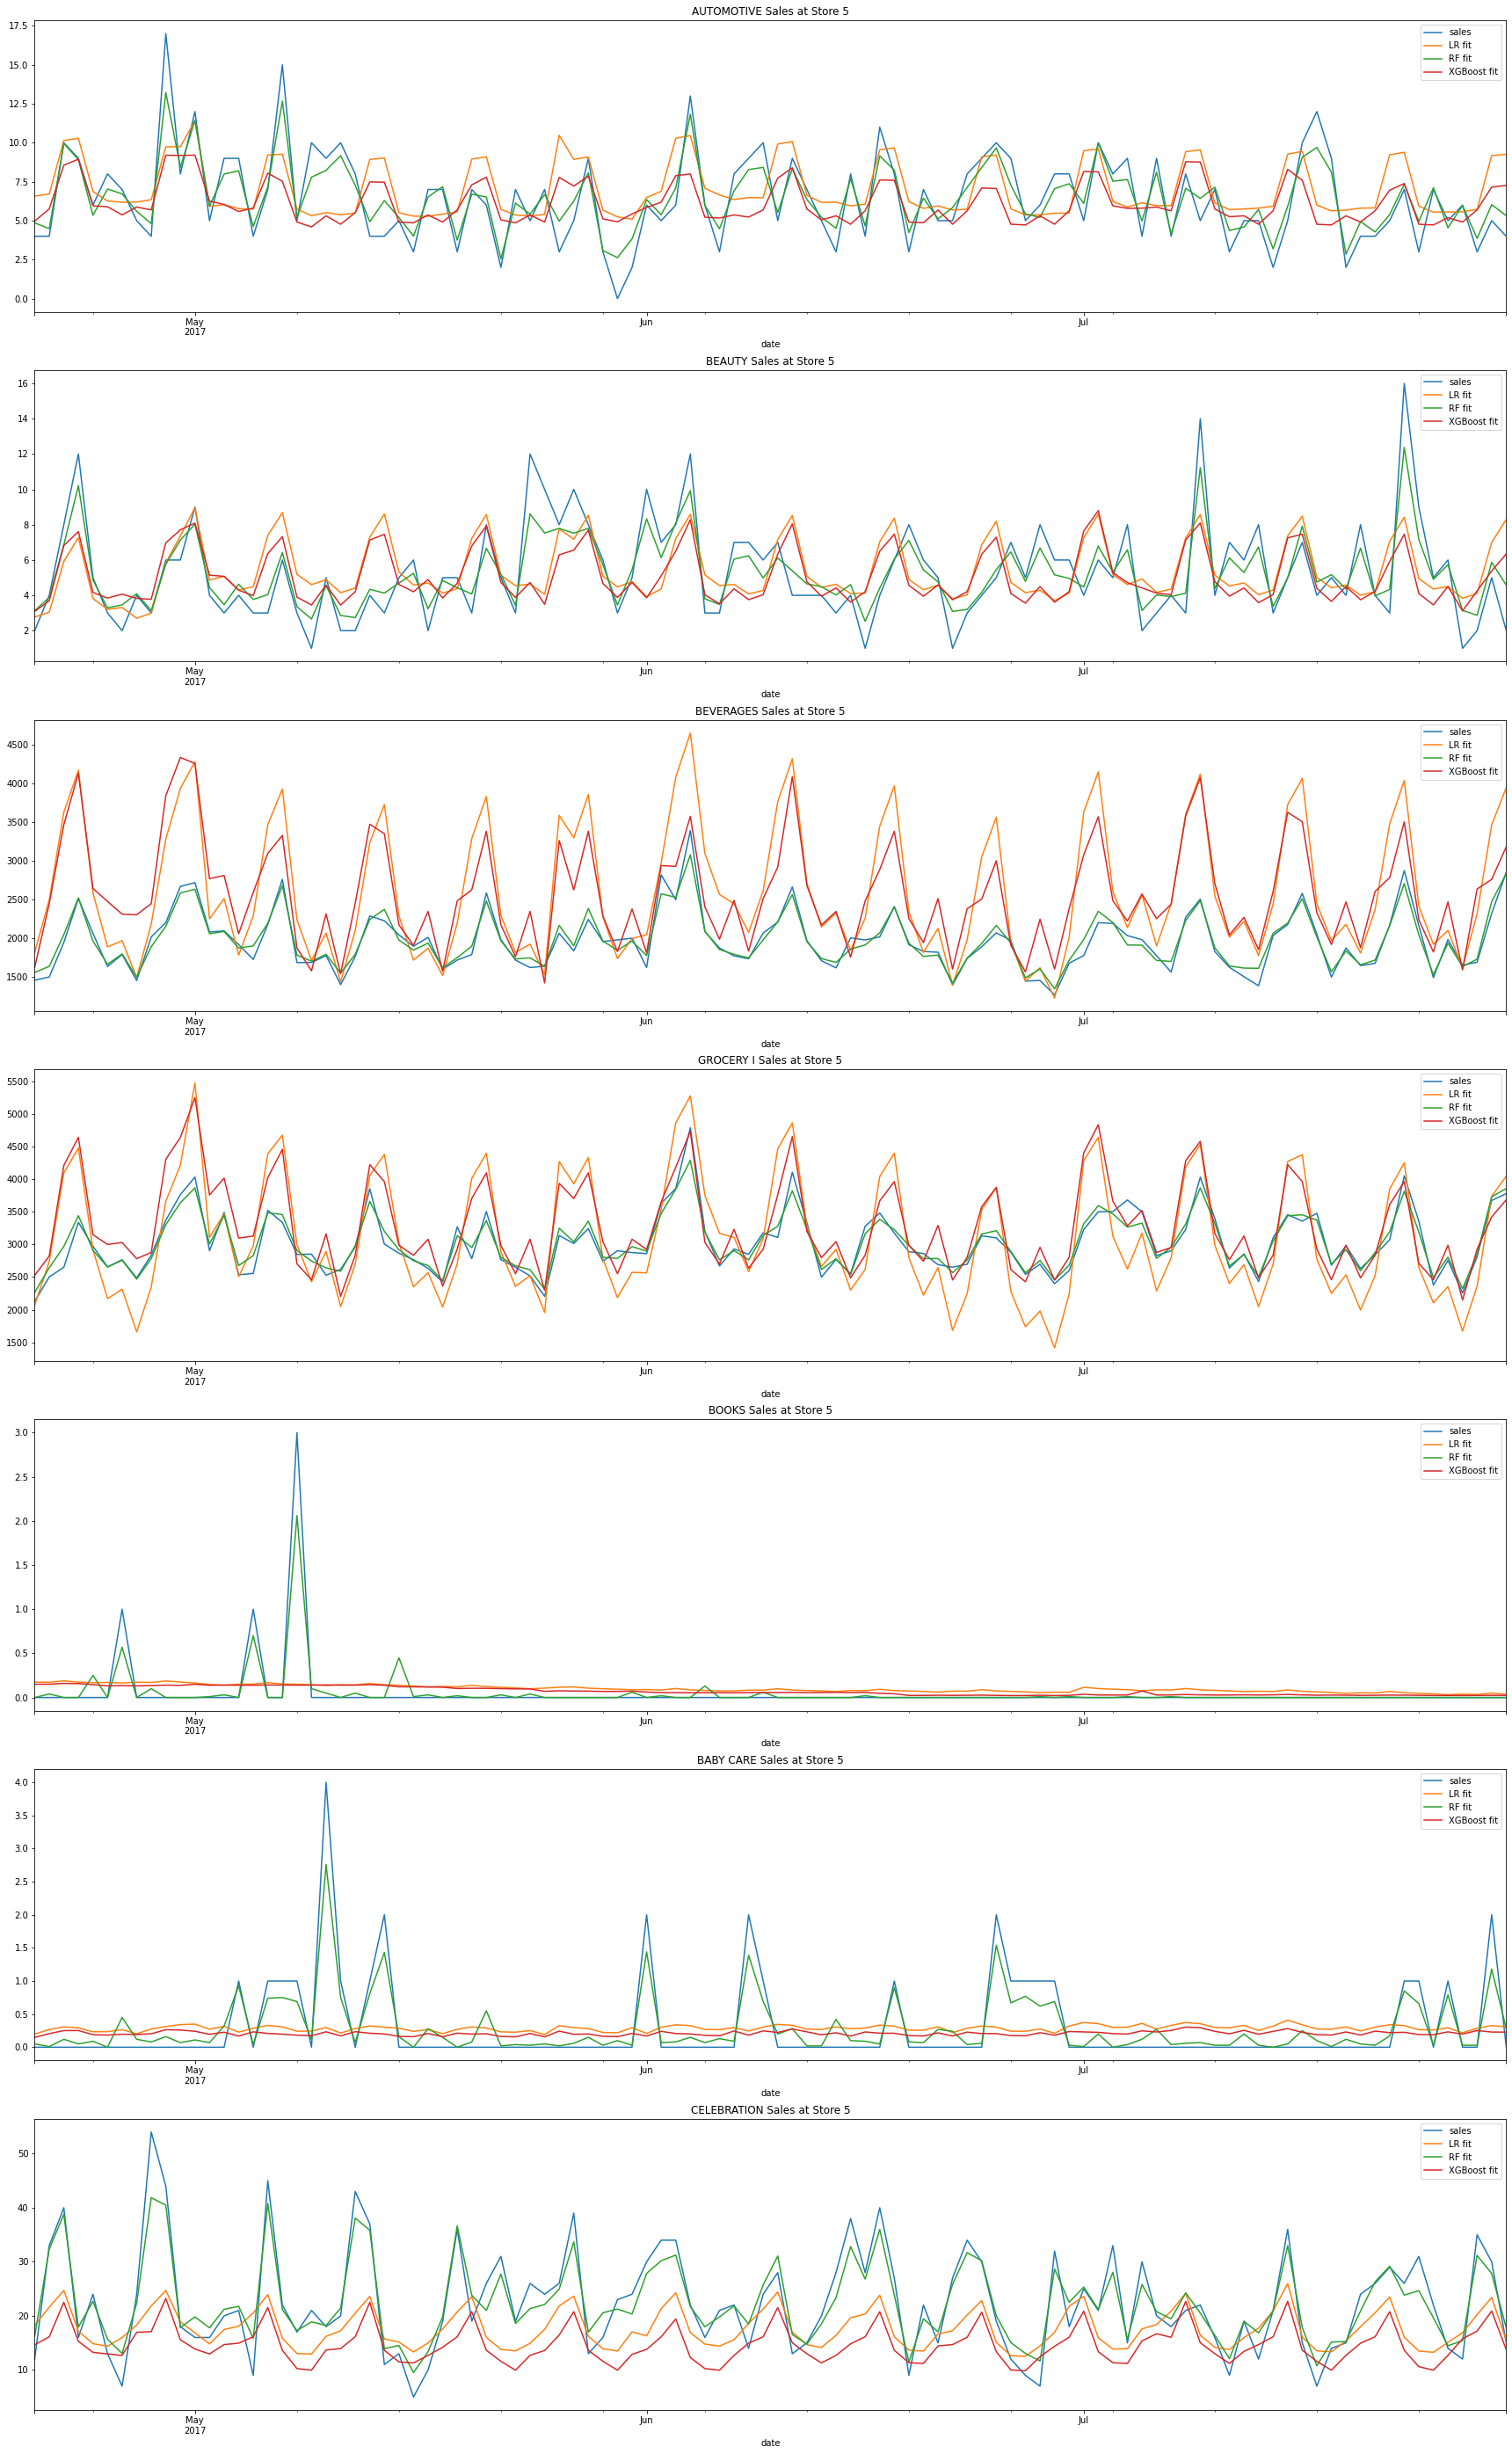

In [45]:
fams = ['AUTOMOTIVE','BEAUTY','BEVERAGES','GROCERY I', "BOOKS", "BABY CARE", "CELEBRATION"]
STORE_NBR = 5
fig, axs = plt.subplots(len(fams), figsize=(30,50))
for i in range(len(fams)):
    axs[i] = y.xs(STORE_NBR, level='store_nbr').loc(axis=1)['sales', fams[i]].loc["2017-04-20":].plot(ax=axs[i],label="sales")
    axs[i] = y_fit_linear.xs(STORE_NBR, level='store_nbr').loc(axis=1)['sales', fams[i]].loc["2017-04-20":].plot(ax=axs[i],label="LR fit")
    axs[i] = y_fit_rf.xs(STORE_NBR, level='store_nbr').loc(axis=1)['sales', fams[i]].loc["2017-04-20":].plot(ax=axs[i],label="RF fit")
    axs[i] = y_fit_xgboost.xs(STORE_NBR, level='store_nbr').loc(axis=1)['sales', fams[i]].loc["2017-04-20":].plot(ax=axs[i],label="XGBoost fit")
    
    axs[i].set_title(f'{fams[i]} Sales at Store {STORE_NBR}');
    axs[i].legend();

for all of the familty types RF outperformes on LR and XGB.

**Evaluation on Train **

The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

The RMSLE is calculated as:
[\sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2}]

In [46]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

LR_rmse = np.sqrt(mean_squared_log_error(y,y_fit_linear))
RF_rmse = np.sqrt(mean_squared_log_error(y,y_fit_rf))
XGB_rmse=np.sqrt(mean_squared_log_error(y,y_fit_xgboost))

print("----------------------------------------")
print("Linear Regression:", LR_rmse)
print("----------------------------------------")
print("Random Forest:", RF_rmse)
print("----------------------------------------")
print("XGBoost:", XGB_rmse)
print("----------------------------------------")


----------------------------------------
Linear Regression: 0.7555633552322004
----------------------------------------
Random Forest: 0.21084841036090077
----------------------------------------
XGBoost: 0.58395374
----------------------------------------


# Evaluation on Validation

In [47]:
X_eval, _,actual_y  = get_X_Y(evaluation_start_date, evaluation_end_date)

In [48]:
LR_forecast = pd.DataFrame(linear_model.predict(X_eval).clip(0.0), index=X_eval.index, columns=y.columns)
RF_forecast = pd.DataFrame(RF_model.predict(X_eval).clip(0.0), index=X_eval.index, columns=y.columns)

X_val=X_eval.copy()
X_val['week']=X_val['week'].astype(int)
XGB_forecast= pd.DataFrame(model_xgboost.predict(X_val).clip(0.0), index=X_eval.index, columns=y.columns)

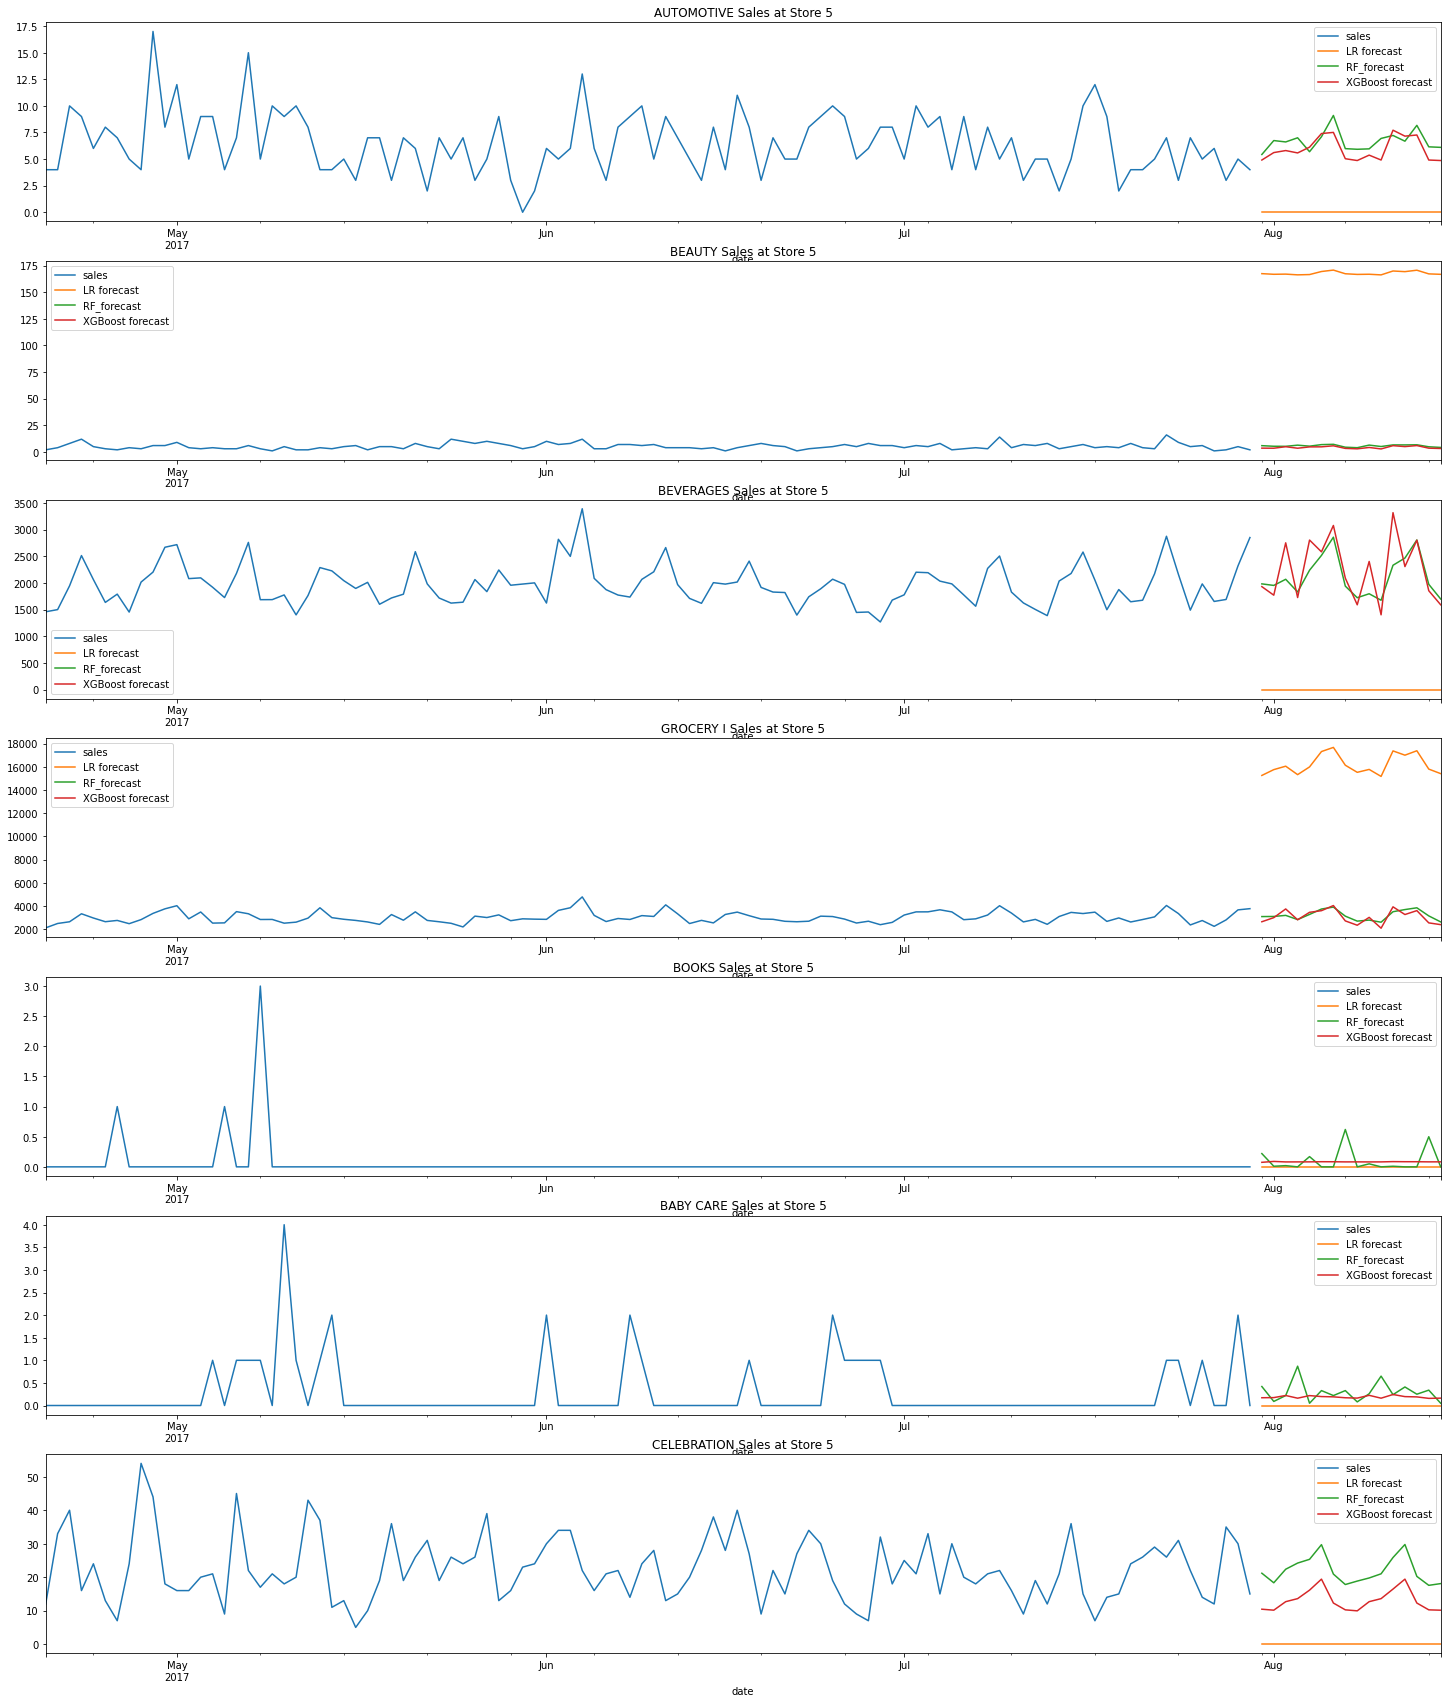

In [49]:
fams = ['AUTOMOTIVE','BEAUTY','BEVERAGES','GROCERY I', "BOOKS", "BABY CARE", "CELEBRATION"]
STORE_NBR = 5
fig, axs = plt.subplots(len(fams), figsize=(25,30))
for i in range(len(fams)):
    axs[i] =  y.xs(STORE_NBR, level='store_nbr').loc(axis=1)['sales', fams[i]].loc["2017-04-20":evaluation_start_date].plot(ax=axs[i],label="sales")
    axs[i] = LR_forecast.xs(STORE_NBR, level='store_nbr').loc(axis=1)['sales', fams[i]].loc[evaluation_start_date:].plot(ax=axs[i],label="LR forecast")
    axs[i] = RF_forecast.xs(STORE_NBR, level='store_nbr').loc(axis=1)['sales', fams[i]].loc[evaluation_start_date:].plot(ax=axs[i],label="RF_forecast")
    axs[i] = XGB_forecast.xs(STORE_NBR, level='store_nbr').loc(axis=1)['sales', fams[i]].loc["2017-04-20":].plot(ax=axs[i],label="XGBoost forecast")
    axs[i].set_title(f'{fams[i]} Sales at Store {STORE_NBR}');
    axs[i].legend();

In [50]:
LR_rmse = np.sqrt(mean_squared_log_error(actual_y,LR_forecast))
RF_rmse = np.sqrt(mean_squared_log_error(actual_y,RF_forecast))
XGB_rmse=np.sqrt(mean_squared_log_error(actual_y,XGB_forecast))

print("----------------------------------------")
print("Linear Regression:", LR_rmse)
print("----------------------------------------")
print("Random Forest:", RF_rmse)
print("----------------------------------------")
print("XGBoost:", XGB_rmse)
print("----------------------------------------")




----------------------------------------
Linear Regression: 3.294231952360449
----------------------------------------
Random Forest: 0.5727905585046117
----------------------------------------
XGBoost: 0.6936997
----------------------------------------


# RF outperforms LR and XGboost- lets perform Hyperparemaeter search

In [51]:

est=[10,100,400,500,600]
maxdepth=[2,100,150,200]
train_start_date=["2017-04-20","2017-05-20","2017-06-20"]#will try to train less as part of hyperparameter choice
min_rmse=100
best_List=[0,0,"2017-04-20"]#number of estimatorsm,max_depth,train start time - by this order
for e in est:
    for m in maxdepth:
        for p in train_start_date:
                X, dp,y  = get_X_Y(p, train_end_date)
                RF_model = RandomForestRegressor(random_state=13, n_jobs=-1,max_depth = m,n_estimators =e,).fit(X,y)#X is train data, y is train lables
                RF_forecast = pd.DataFrame(RF_model.predict(X_eval).clip(0.0), index=X_eval.index, columns=y.columns)#x_eval is evaluation data
                RF_rmse = np.sqrt(mean_squared_log_error(actual_y,RF_forecast))#actual y is evaluation set labels.
                print(f"testing now using estimator number {e}, tree depth {m}, train start data {p}/n rmse for this combination in {RF_rmse}, the minumun rmse till now is{min_rmse}")
                if (RF_rmse< min_rmse):
                    min_rmse=RF_rmse
                    best_list=[e,m,p]
print(best_list)
            
            

testing now using estimator number 10, tree depth 2, train start data 2017-04-20/n rmse for this combination in 0.8045149371603172, the minumun rmse till now is100
testing now using estimator number 10, tree depth 2, train start data 2017-05-20/n rmse for this combination in 0.7836713143991387, the minumun rmse till now is0.8045149371603172
testing now using estimator number 10, tree depth 2, train start data 2017-06-20/n rmse for this combination in 0.7824705236682794, the minumun rmse till now is0.7836713143991387
testing now using estimator number 10, tree depth 100, train start data 2017-04-20/n rmse for this combination in 0.5919971895927044, the minumun rmse till now is0.7824705236682794
testing now using estimator number 10, tree depth 100, train start data 2017-05-20/n rmse for this combination in 0.5599282562219448, the minumun rmse till now is0.5919971895927044
testing now using estimator number 10, tree depth 100, train start data 2017-06-20/n rmse for this combination in 0.

# Submission on test set

will train the model on all of the existing training data( train and evaluation periods), using n_estimators=400, max depth=100, the training period starts at 2017-05-20 


In [52]:
X_training, _,y_training  = get_X_Y("2017-05-20", evaluation_end_date)
RF_model = RandomForestRegressor(random_state=13, n_jobs=-1,max_depth = 100,n_estimators =400).fit(X_training,y_training)

In [53]:
X_test, _, y_pred = get_X_Y(test_start_date, test_end_date)
X_test

trend  sin(1,freq=W-SUN)  cos(1,freq=W-SUN)  \
date       store_nbr                                                
2017-08-16 1            1.0           0.974928          -0.222521   
           2            1.0           0.974928          -0.222521   
           3            1.0           0.974928          -0.222521   
           4            1.0           0.974928          -0.222521   
           5            1.0           0.974928          -0.222521   
...                     ...                ...                ...   
2017-08-31 50          16.0           0.433884          -0.900969   
           51          16.0           0.433884          -0.900969   
           52          16.0           0.433884          -0.900969   
           53          16.0           0.433884          -0.900969   
           54          16.0           0.433884          -0.900969   

                      sin(2,freq=W-SUN)  cos(2,freq=W-SUN)  sin(3,freq=W-SUN)  \
date       store_nbr                                                            
2017-08-16 1                  -0.433884          -0.900969          -0.781831   
           2                  -0.433884          -0.900969          -0.781831   
           3                  -0.433884          -0.900969          -0.781831   
           4                  -0.433884          -0.900969          -0.781831   
           5                  -0.433884          -0.900969          -0.781831   
...                                 ...                ...                ...   
2017-08-31 50                 -0.781831           0.623490           0.974928   
           51                 -0.781831           0.623490           0.974928   
           52                 -0.781831           0.623490           0.974928   
           53                 -0.781831           0.623490           0.974928   
           54                 -0.781831           0.623490           0.974928   

                      cos(3,freq=W-SUN)  onpromotion  cluster  city_Babahoyo  \
date       store_nbr                                                           
2017-08-16 1                   0.623490    15.878788       13              0   
           2                   0.623490    15.939394       13              0   
           3                   0.623490    15.454545        8              0   
           4                   0.623490    15.787879        9              0   
           5                   0.623490    15.636364        4              0   
...                                 ...          ...      ...            ...   
2017-08-31 50                 -0.222521     6.030303       14              0   
           51                 -0.222521     5.333333       17              0   
           52                 -0.222521     6.090909       11              0   
           53                 -0.222521     4.636364       13              0   
           54                 -0.222521     4.363636        3              0   

                      ...  quarter  Payday  WD  weekday_0  weekday_1  \
date       store_nbr  ...                                              
2017-08-16 1          ...        3       0   1          0          0   
           2          ...        3       0   1          0          0   
           3          ...        3       0   1          0          0   
           4          ...        3       0   1          0          0   
           5          ...        3       0   1          0          0   
...                   ...      ...     ...  ..        ...        ...   
2017-08-31 50         ...        3       1   1          0          0   
           51         ...        3       1   1          0          0   
           52         ...        3       1   1          0          0   
           53         ...        3       1   1          0          0   
           54         ...        3       1   1          0          0   

                      weekday_2  weekday_3  weekday_4  weekday_5  weekday_6  
date       sto

In [54]:
y_pred = pd.DataFrame(RF_model.predict(X_test).clip(0.0), index=X_test.index, columns=y_pred.columns)
y_pred = y_pred.reset_index()
y_pred['store_nbr'] = y_pred['store_nbr'].astype(str)
y_pred = y_pred.set_index(['date', 'store_nbr']).sort_index().stack('family')
y_pred

sales
date       store_nbr family                                 
2017-08-16 1         AUTOMOTIVE                     5.227500
                     BABY CARE                      0.037500
                     BEAUTY                         7.847500
                     BEVERAGES                   3009.882500
                     BOOKS                          0.020000
...                                                      ...
2017-08-31 9         POULTRY                      298.218327
                     PREPARED FOODS                78.483863
                     PRODUCE                      987.053196
                     SCHOOL AND OFFICE SUPPLIES     8.006667
                     SEAFOOD                       12.791624

[28512 rows x 1 columns]

In [55]:
sub = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'), index_col='id')
sub['sales'] = y_pred.values
sub

,sales
id,
3000888,5.227500
3000889,0.037500
3000890,7.847500
3000891,3009.882500
3000892,0.020000
...,...
3029395,298.218327
3029396,78.483863
3029397,987.053196


In [56]:
sub.to_csv('submission.csv', index=True)

Subbmition results of defult RF parameters

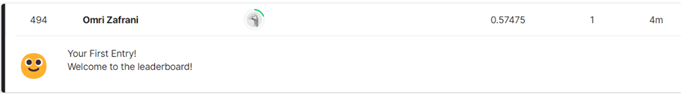

submittion results with tunning parameters and training since the opening of the last store opening(20-04-2017)

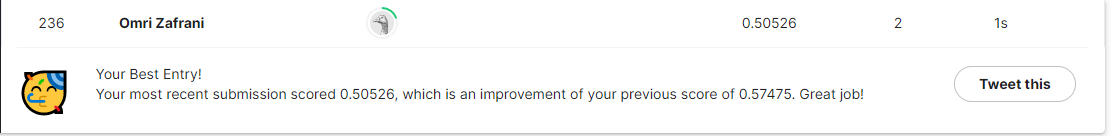


Submmition results post tunning parameters and training less(train start date: 20-05-2017)

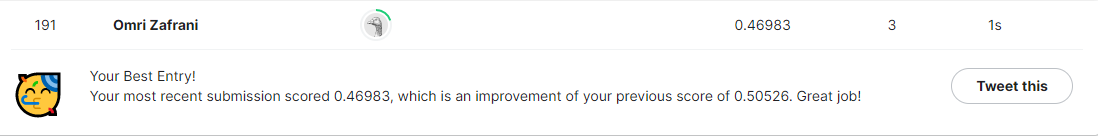


# Summery
In this competition, the main goal was to predict unit sales for thousands of items sold
at different stores of Favorita. 
First, the data was analysed. A deep exploration of the features and the relations between them was done. Some data has been visualized, to understand the correlation, the impact and the causality. For example how the day in the week affect the number of sales.
Then, in order to increase the accuracy of the model, the training data has been splitted into validation set and training set. 
After that, three forecasting methods has been tested: linear regression, random forest regression and GXBoost.
The model was firstly tested on the training set by RMSE, and secondly on the validation set by RMSE either. The forecasting method which fit the best to the data, with the minimum value of RMSE is the Random Forest Regression. 
When the forecasting method has been choose, the tuning parameters were evaluated to get the minimal error on the validation set. The tuning parameters controlled were the number of trees in the forest, randomness of the bootstrapping of the samples used when building trees and the training period. As the tuning parameters been found, the model was applied on the test set. 
By using the default parameters the accuracy of the model on the test set was 0.50526. 
When the tuning parameters were added, the accuracy of the model on the test set was 0.46983.
As shown, there is a significant difference between the both, so we can make sure that the model has been improved after added tuning parameters.
By using this model, the sales values can be estimated with high certainty. In a following work, in order to further improve the results of the forecasting, a different way of validation set splitting will be apply and the forecasting method will be Moving Average that can trend-following indicator based on past sales.



# References
1. Machine Learning Benchmarks and Random Forest Regression, Segal, Mark R, University of California, San Francisco, April 2004. 
2. Regression and Time Series Model selection, Allan McQuarrie and Chih Ling Tsai, University of California, Davis, 1998. 
3. http://dominica.gov.dm/about-dominica/public-holidays.
4. Xu, Y., Goodacre, R. On Splitting Training and Validation Set: A Comparative Study of Cross-Validation, Bootstrap and Systematic Sampling for Estimating the Generalization Performance of Supervised Learning, 2018.
5. https://www.statsmodels.org/devel/generated/statsmodels.tsa.deterministic.CalendarFourier.html
6. https://www.statsmodels.org/devel/generated/statsmodels.tsa.deterministic.DeterministicProcess.html 
